In [3]:
! pip install lifelines ## in case you do not have survival analysis kit

You should consider upgrading via the '/Users/yuchenghsu/opt/anaconda3/bin/python -m pip install --upgrade pip' command.


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sweetviz as sv
import lifelines as ll

# Data Overview

In [5]:
# read in the data. join_date & quit_date should be dates, so convert them into date objects for further use.
df = pd.read_csv("employee_retention.csv", parse_dates=['join_date', 'quit_date'])
df.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



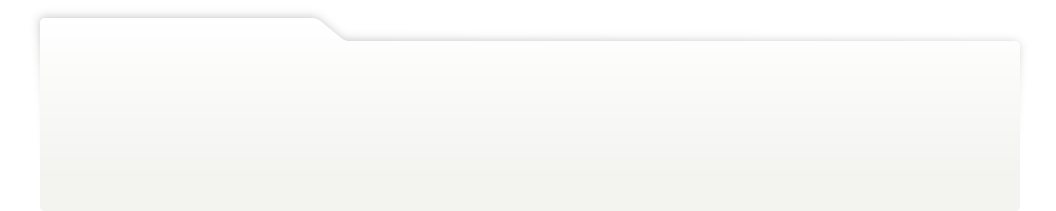
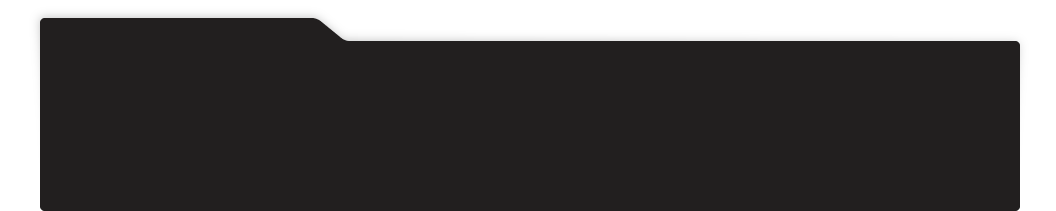
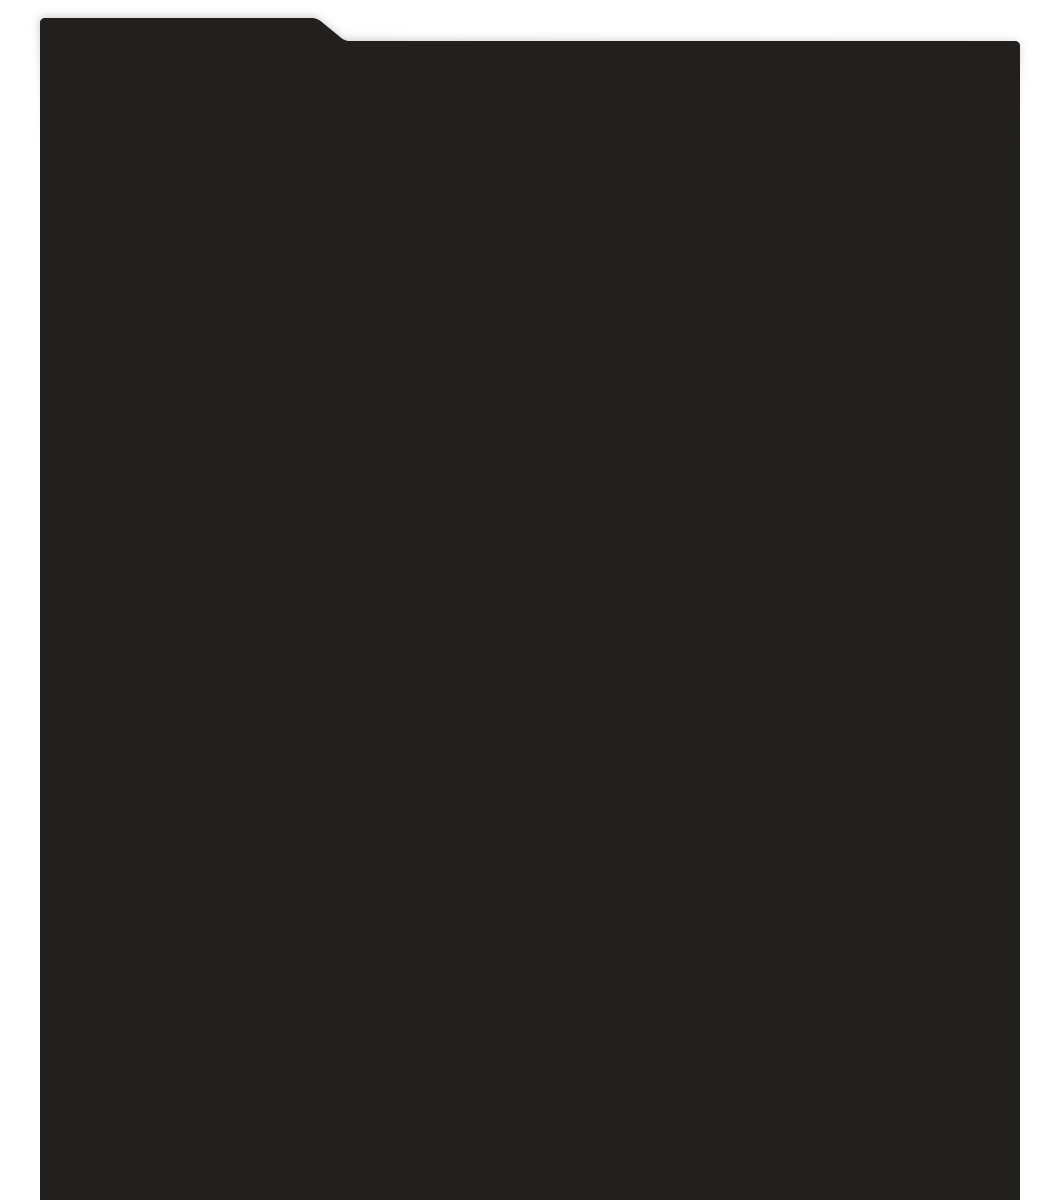
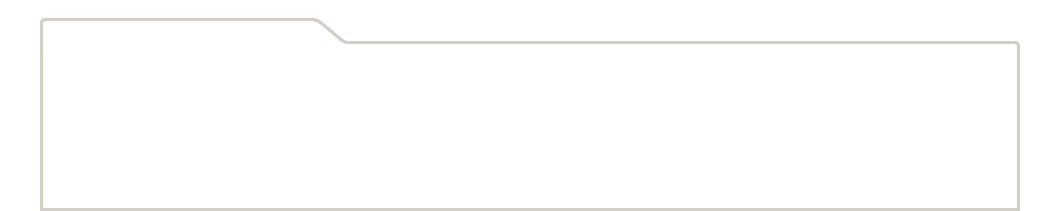
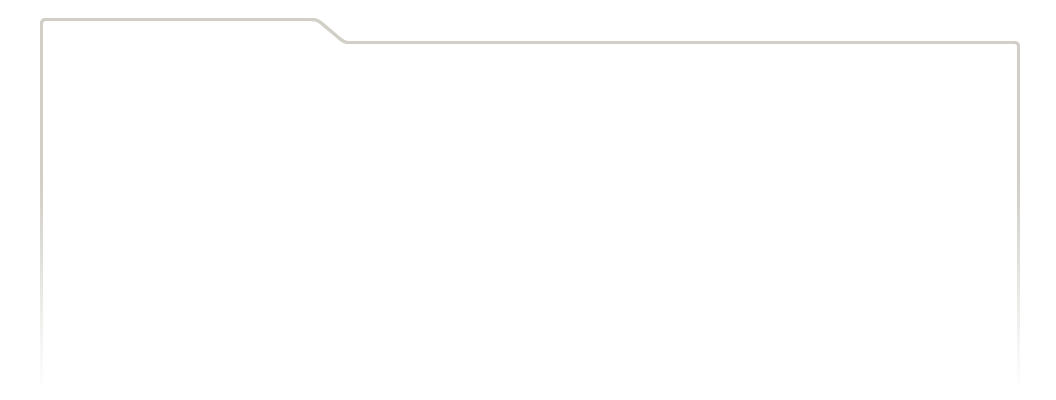
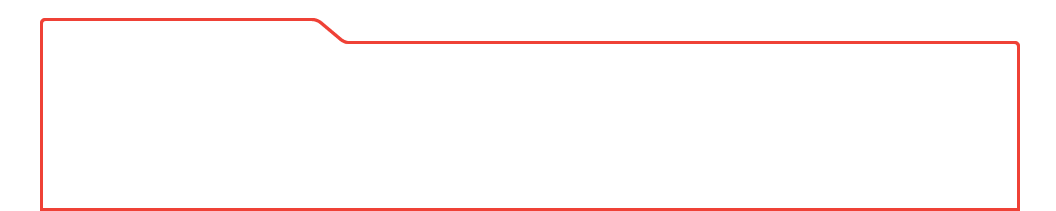
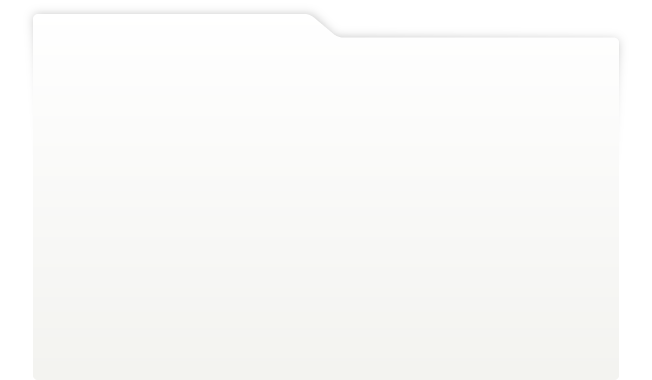
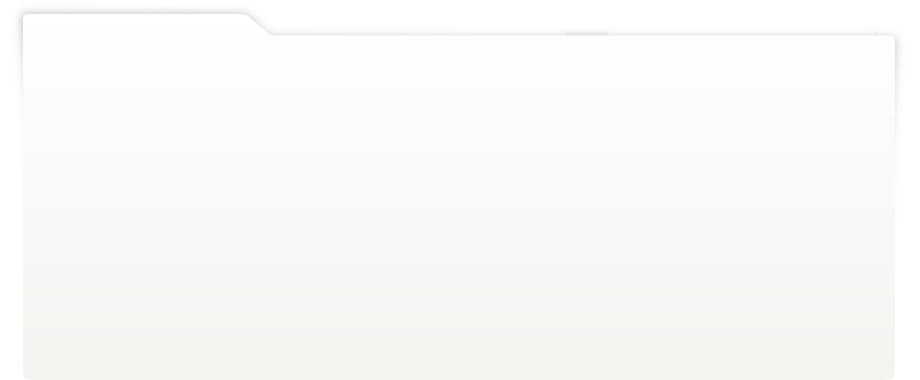
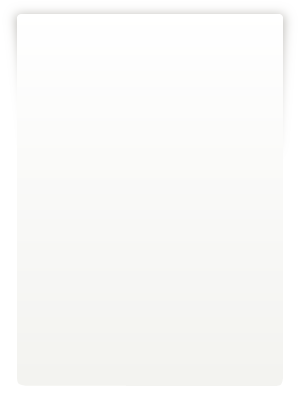
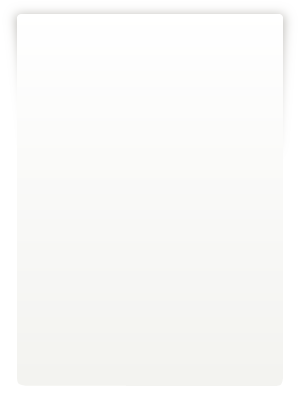
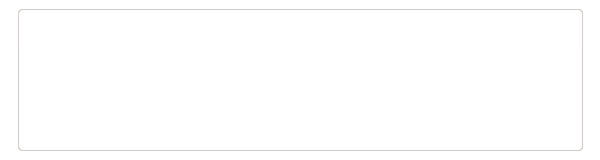
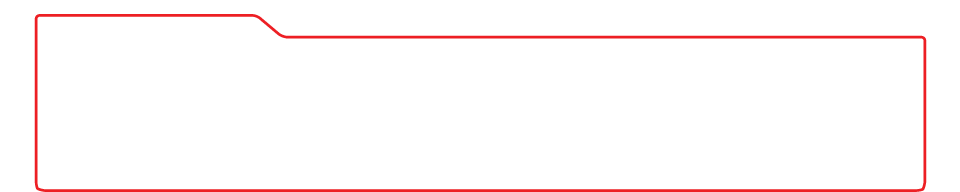
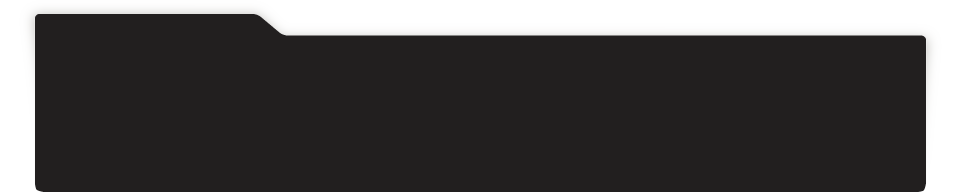
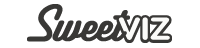
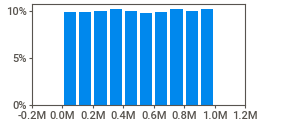
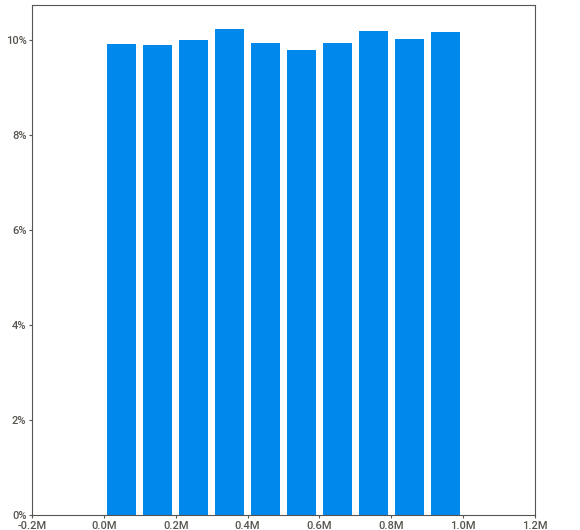
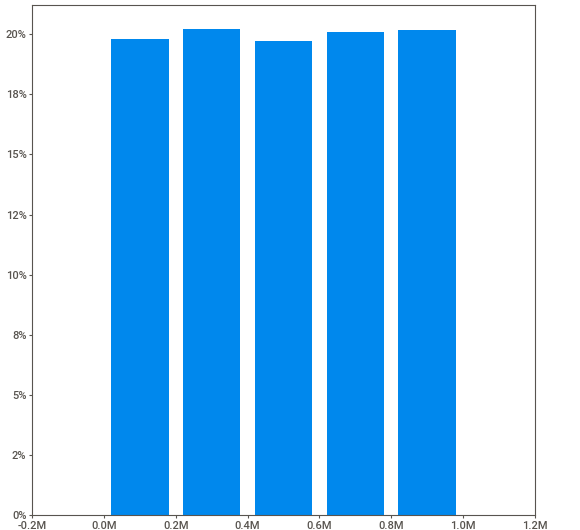
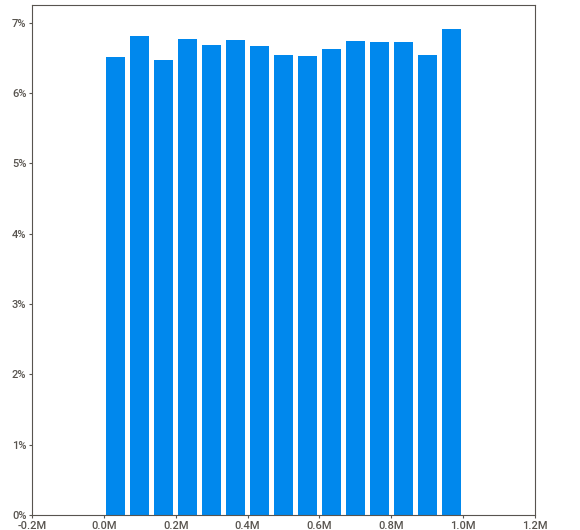
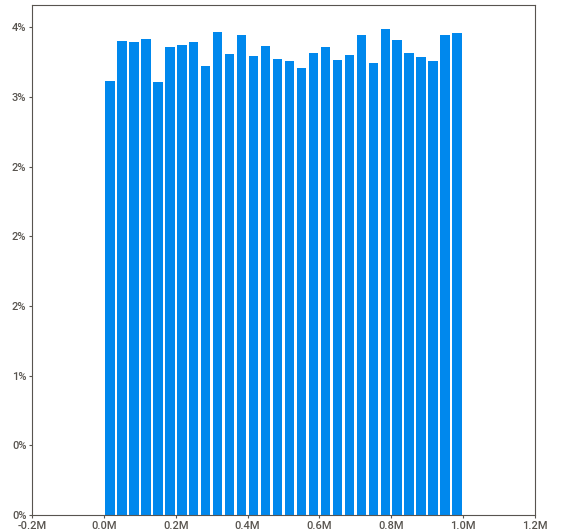
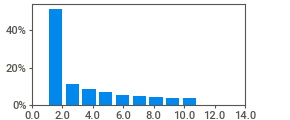
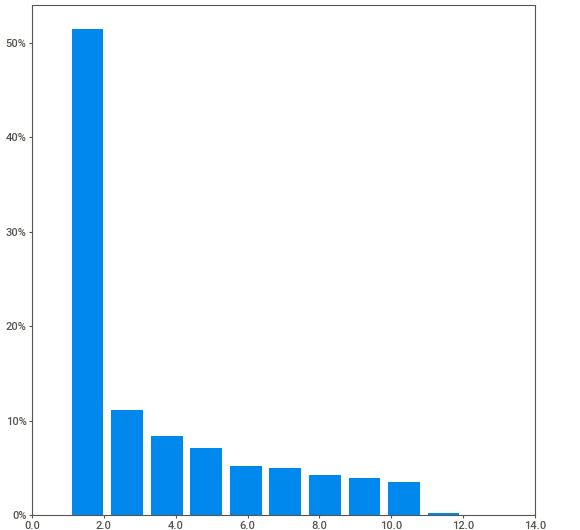
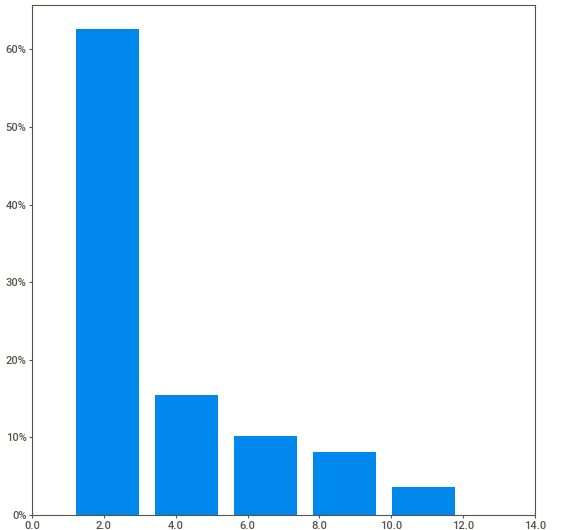
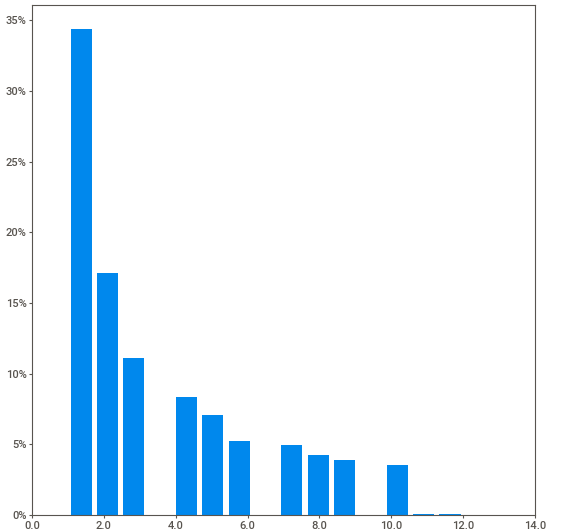
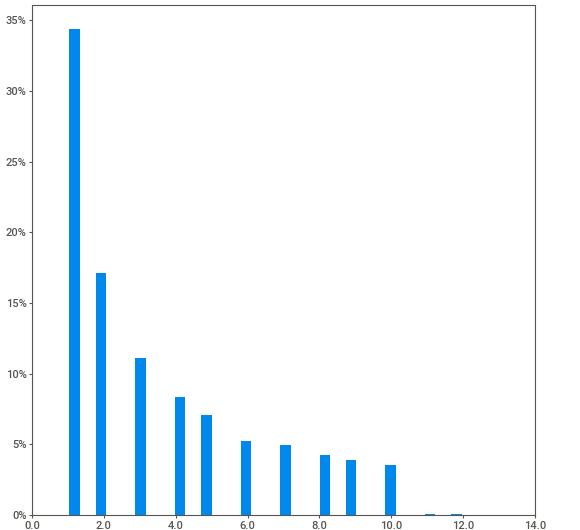
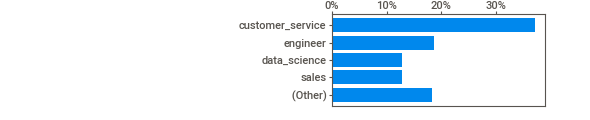
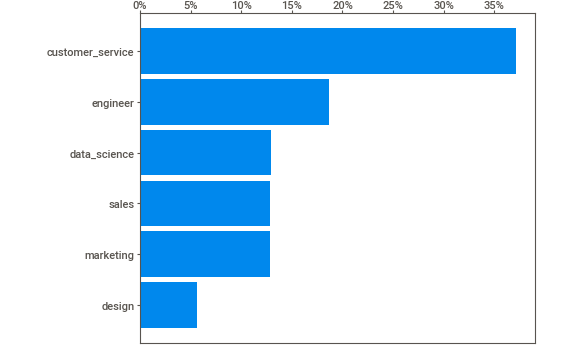
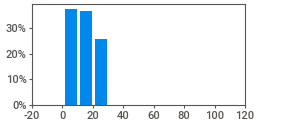
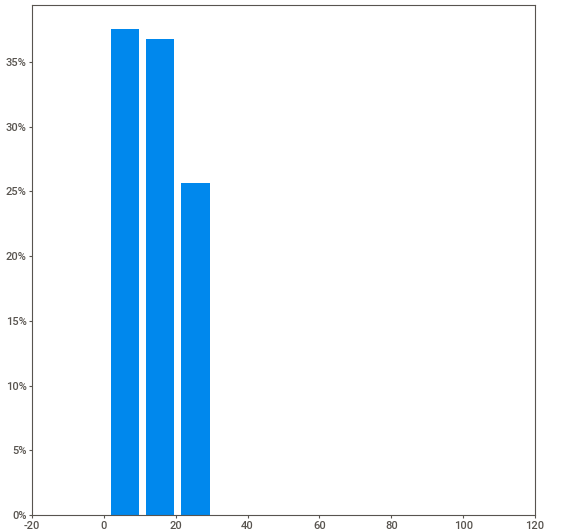
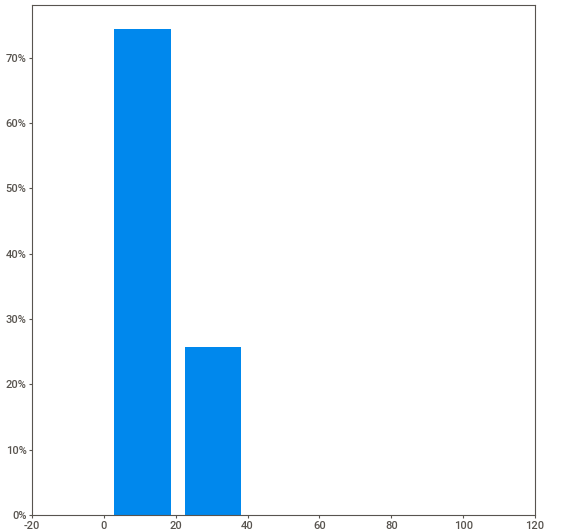
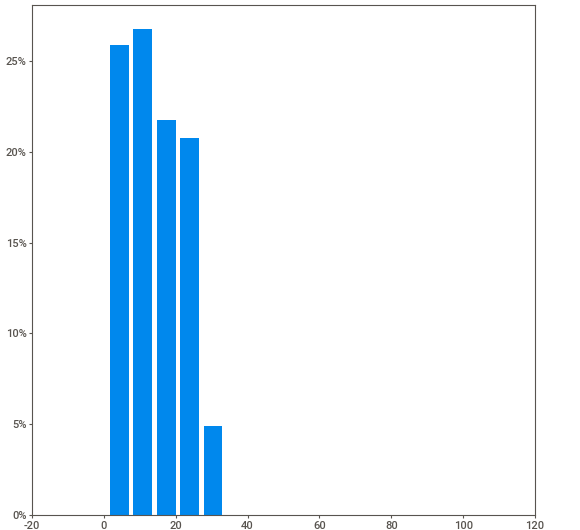
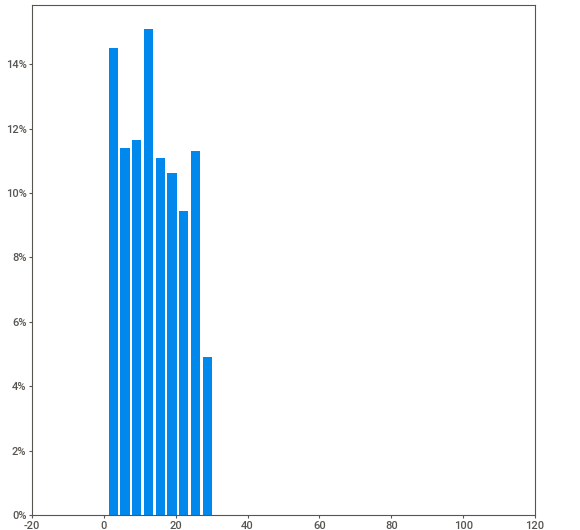
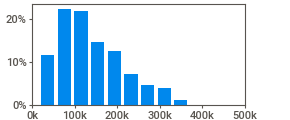
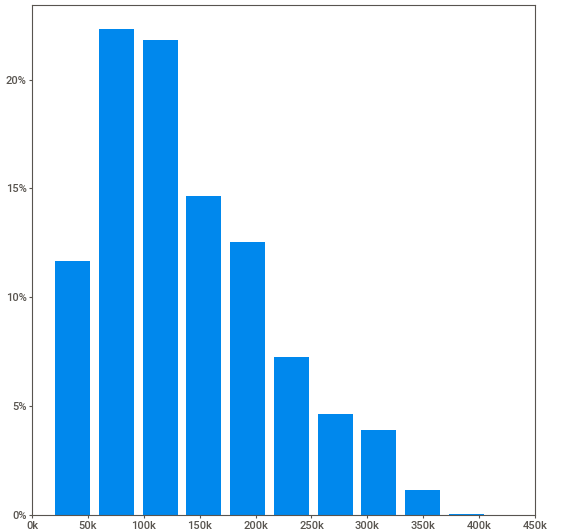
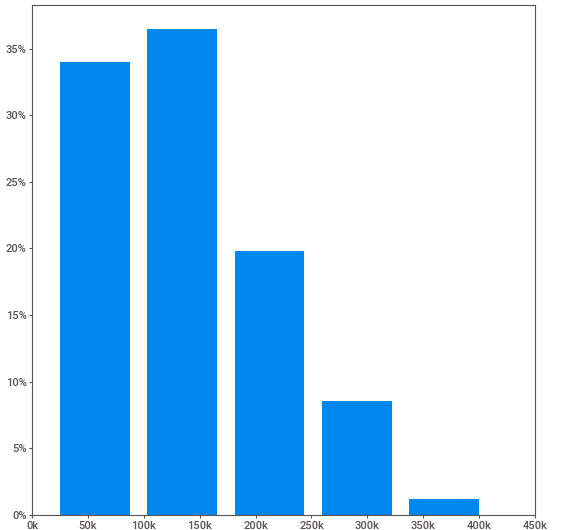
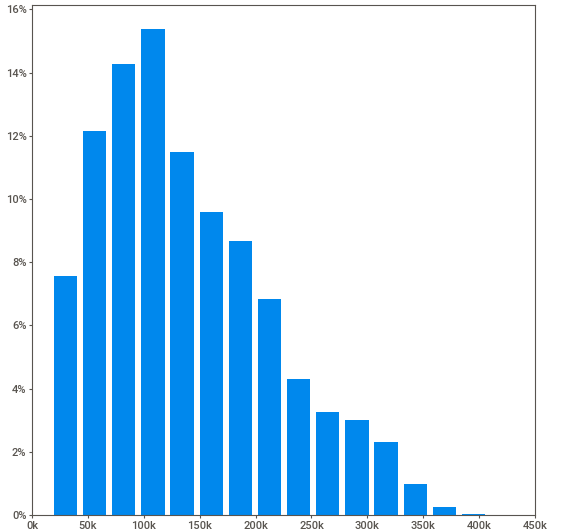
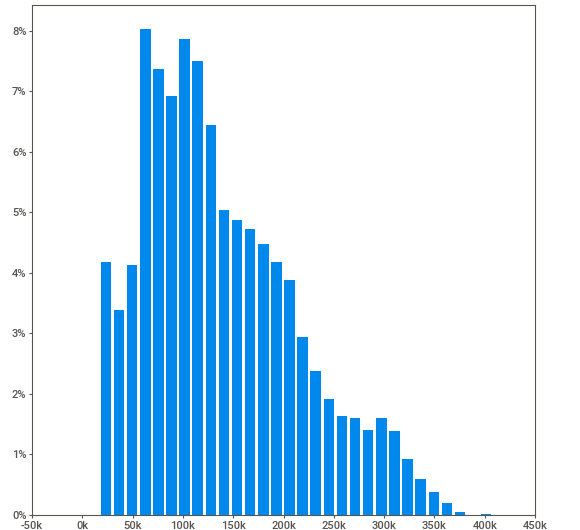
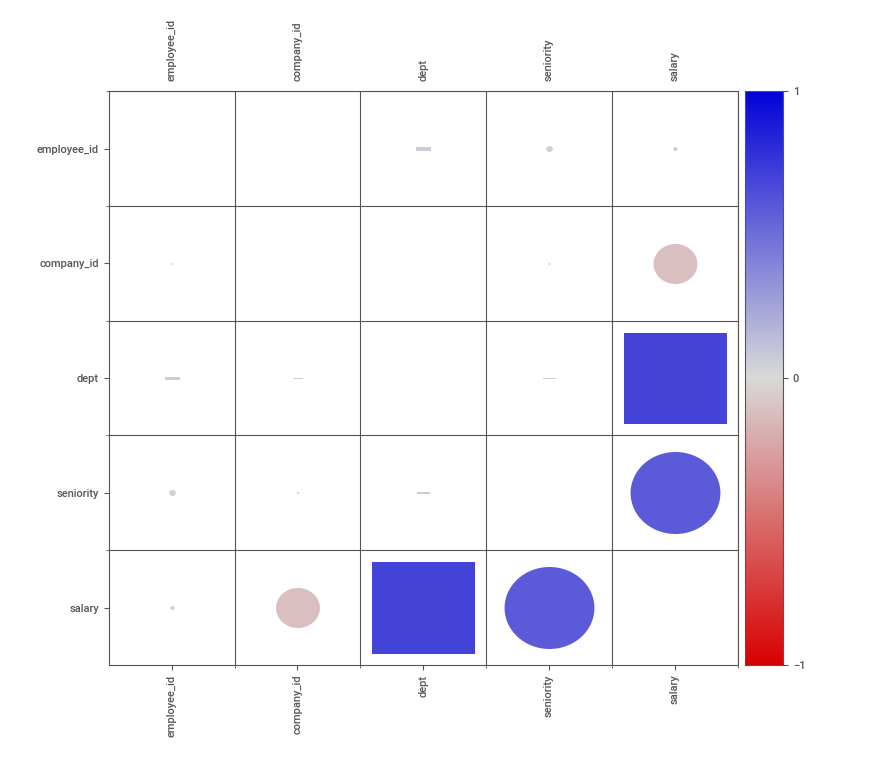
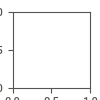

In [6]:
report=sv.analyze(df)
report.show_notebook()

## Findings
- there are 7 columns in total, and only quit_date has missing values. (It is reasonable as they are stay in the company)
- Abnormal value in seniority
- Imbalanced in company 11 and 12 

**Abnormal Values**

- the max value in seniority column seems strange. zoom in.

In [7]:
df['seniority'].value_counts().sort_values(ascending=True)

99       1
98       1
28     585
29     626
27     642
26     694
25     715
24     743
22     764
21     782
23     785
20     844
1      861
18     872
3      881
17     893
13     894
4      895
19     910
15     911
14     920
11     924
10     927
7      928
5      936
16     936
2      942
9      944
6      950
12     988
8     1008
Name: seniority, dtype: int64

In [8]:
df['company_id'].value_counts().sort_values(ascending=True)

11      16
12      24
10     865
9      961
8     1047
7     1224
6     1291
5     1755
4     2062
3     2749
2     4222
1     8486
Name: company_id, dtype: int64

In [9]:
# According to the definition of seniority, which is, YOE before joining the company, seniority of 99 or 98 is obviously impossible. 
# Thus, we decided to drop the rows
df = df[-((df['seniority']==99) | (df['seniority']==98))]
df = df[-((df['company_id']==11) | (df['company_id']==12))]

In [10]:
#  take a look at the summary of the data set
print(df.info())
print(df.describe())
print(df.describe(include=['datetime64[ns]']))
print(df.describe(include=['object']))

# Now the data makes more sense.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24660 entries, 0 to 24699
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   employee_id  24660 non-null  float64       
 1   company_id   24660 non-null  int64         
 2   dept         24660 non-null  object        
 3   seniority    24660 non-null  int64         
 4   salary       24660 non-null  float64       
 5   join_date    24660 non-null  datetime64[ns]
 6   quit_date    13484 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(2), int64(2), object(1)
memory usage: 1.5+ MB
None
         employee_id    company_id     seniority         salary
count   24660.000000  24660.000000  24660.000000   24660.000000
mean   501715.966951      3.413544     14.123682  138258.272506
std    288912.806352      2.681708      8.053616   76052.618716
min        36.000000      1.000000      1.000000   17000.000000
25%    250281.500000      1.000000      7.000

/var/folders/b7/1c9pljd128l_p12f9bxl2n080000gn/T/ipykernel_32586/1737509355.py:4: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  print(df.describe(include=['datetime64[ns]']))


# Survival regression

In [11]:
## Encoding We use customer service dept in company 1 as the reference group
X=pd.concat([pd.get_dummies(df['company_id'],prefix="company").iloc[:,1:],pd.get_dummies(df['dept'],prefix="dept").iloc[:,1:],df[['seniority','salary']]],axis=1)

In [12]:
X

,company_2,company_3,company_4,company_5,company_6,company_7,company_8,company_9,company_10,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales,seniority,salary
0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,28,89000.0
1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,20,183000.0
2,0,0,1,0,0,0,0,0,0,0,0,0,1,0,14,101000.0
3,0,0,0,0,0,1,0,0,0,0,0,0,0,0,20,115000.0
4,1,0,0,0,0,0,0,0,0,1,0,0,0,0,23,276000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24695,0,0,0,0,0,0,0,0,0,1,0,0,0,0,5,172000.0
24696,0,0,0,0,1,0,0,0,0,0,0,0,1,0,7,88000.0
24697,0,1,0,0,0,0,0,0,0,0,0,0,0,0,16,97000.0
24698,0,0,1,0,0,0,0,0,0,0,0,1,0,0,10,160000.0


In [13]:
## Adding duration term and the observed event (0=event (quit) not happen, 1= quit the job)
X['T'],X["E"]=ll.utils.datetimes_to_durations(df.join_date,df.quit_date,freq="M")


In [14]:
cph = ll.CoxPHFitter()
cph.fit(X, duration_col='T', event_col='E')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 24660 total observations, 11176 right-censored observations>
             duration col = 'T'
                event col = 'E'
      baseline estimation = breslow
   number of observations = 24660
number of events observed = 13484
   partial log-likelihood = -131667.75
         time fit was run = 2022-12-20 15:10:26 UTC

---
                    coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                 
company_2          -0.06       0.94       0.03            -0.11            -0.01                 0.89                 0.99
company_3          -0.01       0.99       0.03            -0.07             0.05                 0.93                 1.05
company_4           0.01       1.01       0.03            -0.06             0.08                 0.94                 1.08
company_5          -0.00       1.00       0.04            -0.07             0.07                 0.93                 1.07
company_6          -0.02       0.98       0.04            -0.10             0.06                 0.91                 1.07
company_7           0.02       1.02       0.04            -0.06             0.10                 0.94                 1.10
company_8          -0.00       1.00       0.04            -0.09             0.09                 0.91                 1.09
company_9          -0.02       0.98       0.05            -0.12             0.07                 0.89                 1.07
company_10         -0.01       0.99       0.05            -0.10             0.09                 0.90                 1.09
dept_data_science   0.07       1.07       0.04            -0.01             0.16                 0.99                 1.17
dept_design         0.09       1.10       0.04             0.01             0.17                 1.01                 1.19
dept_engineer       0.03       1.03       0.04            -0.05             0.11                 0.95                 1.12
dept_marketing      0.09       1.10       0.03             0.03             0.16                 1.03                 1.17
dept_sales          0.13       1.14       0.03             0.07             0.19                 1.08                 1.21
seniority           0.01       1.01       0.00             0.00             0.01                 1.00                 1.01
salary             -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                    cmp to     z      p   -log2(p)
covariate                                         
company_2             0.00 -2.33   0.02       5.65
company_3             0.00 -0.27   0.79       0.35
company_4             0.00  0.26   0.79       0.34
company_5             0.00 -0.11   0.91       0.14
company_6             0.00 -0.38   0.70       0.51
company_7             0.00  0.42   0.68       0.56
company_8             0.00 -0.06   0.96       0.07
company_9             0.00 -0.53   0.59       0.75
company_10            0.00 -0.19   0.85       0.24
dept_data_science     0.00  1.69   0.09       3.45
dept_design           0.00  2.28   0.02       5.45
dept_engineer         0.00  0.74   0.46       1.13
dept_marketing        0.00  3.07 <0.005       8.87
dept_sales            0.00  4.32 <0.005      15.94
seniority             0.00  4.50 <0.005      17.18
salary                0.00 -5.41 <0.005      23.91
---
Concordance = 0.53
Partial AIC = 263367.51
log-likelihood ratio test = 112.67 on 16 df
-log2(p) of ll-ratio test = 52.68

Coef>0 (exp(coef)>1, hazard ratio) means the variable makes the employee easier to quit, and vise versa

# Findings

1. Comapmny 2 is doing better in retaining employee
2. Design, marketing and sales department are hard to retain employee
3. more senior people are easier to quit (maybe retire?)
4. Salary helps, but the effect is minor

# Soime plots 
## Overall survivial

Text(55, 0.6, '46.33 % of people stay in the first 48 month')

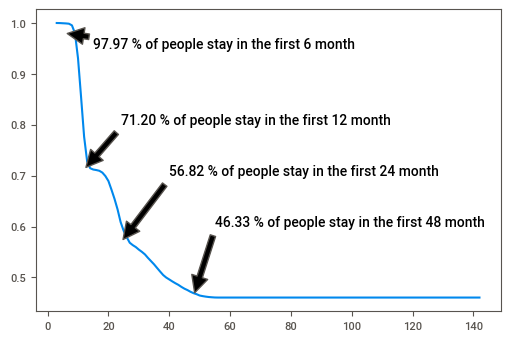

In [15]:
surv=cph.predict_survival_function(X)
surv_rate=surv.mean(axis=1)
fig, ax =plt.subplots()
ax.plot(surv_rate)
ax.annotate('%.2f %% of people stay in the first 6 month'%(surv_rate.iloc[6]*100),(6,surv_rate.iloc[6]),(15,0.95),arrowprops=dict(facecolor='black', shrink=0.05),)
ax.annotate('%.2f %% of people stay in the first 12 month'%(surv_rate.iloc[12]*100),(12,surv_rate.iloc[12]),(24,0.8),arrowprops=dict(facecolor='black', shrink=0.05),)
ax.annotate('%.2f %% of people stay in the first 24 month'%(surv_rate.iloc[24]*100),(24,surv_rate.iloc[24]),(40,0.7),arrowprops=dict(facecolor='black', shrink=0.05),)
ax.annotate('%.2f %% of people stay in the first 48 month'%(surv_rate.iloc[48]*100),(48,surv_rate.iloc[48]),(55,0.6),arrowprops=dict(facecolor='black', shrink=0.05),)

## Partial effect 

### Company 2 

<AxesSubplot:>

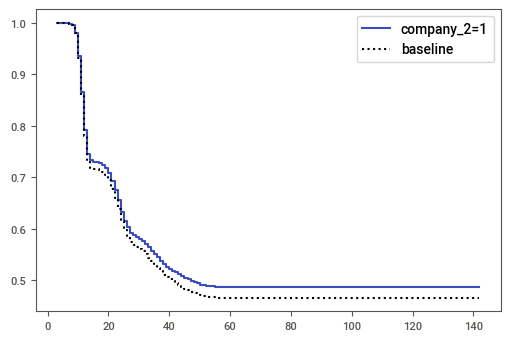

In [19]:
cph.plot_partial_effects_on_outcome("company_2",values=[1],cmap='coolwarm') ## Company 2 retain better for people keep working in company 2

### Sales department

<AxesSubplot:>

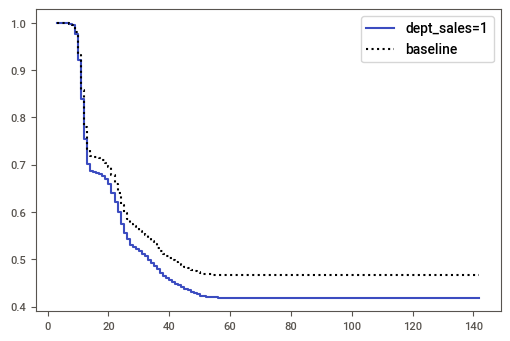

In [24]:
cph.plot_partial_effects_on_outcome("dept_sales",values=[1],cmap='coolwarm') ## Sales deop in the early career or late career

### Salary

<AxesSubplot:>

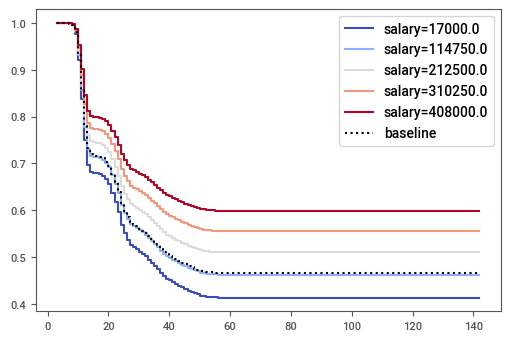

In [20]:
cph.plot_partial_effects_on_outcome("salary",values=np.linspace(min(df.salary),max(df.salary),5),cmap='coolwarm') ## High paid people are easier to stay

### Seniority

<AxesSubplot:>

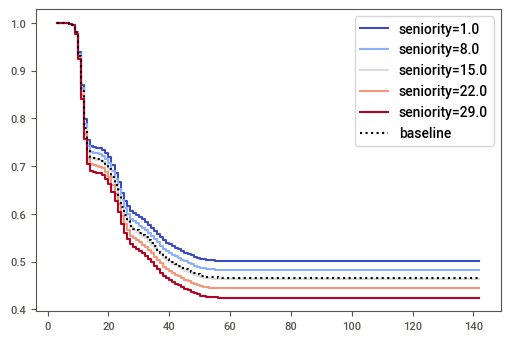

In [21]:
cph.plot_partial_effects_on_outcome("seniority",values=np.linspace(min(df.seniority),max(df.seniority),5),cmap='coolwarm') 